In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.set_loglevel(level = 'warning')

# Load Model Predictions

In [2]:
model_paths = {
    'PS AutoReg Neural Net, Category Features': '/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100/models/0404_MIND_category2/sequential:epochs=1000,bs=100,lr=0.001,wd=0.01,MLP_layers=3,MLP_width=50,weight_factor=1,max_obs=500,repeat_suffstat=10,category=1,sample_frac=1.0,p_alpha=1,sched=constant,seed=2340923',
    'PS AutoReg Neural Net, Text Features': '/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100/models/seq_bert_rerun/sequential:epochs=500,bs=100,lr=1e-05,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,repeat_suffstat=100,bert_lr=1e-08,sample_frac=1.0,p_alpha=1,seed=2340923', 
    'PS AutoReg Beta-Bernoulli, Text (Empirical Bayes) ': '/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100/models/seq_bb_sweep_ab_relu/sequential:epochs=500,bs=100,lr=1e-05,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,repeat_suffstat=100,bert_lr=1e-08,sample_frac=1.0,p_alpha=1,sched=constant,BB=True,alphabeta=True,seed=2340923',
}

In [3]:
prediction_dicts = {}
for name, run_dir in model_paths.items():
    preds = torch.load(run_dir + '/best_loss_predictions.pt')
    prediction_dicts[name] = preds

prediction_dicts.keys()

dict_keys(['PS AutoReg Neural Net, Category Features', 'PS AutoReg Neural Net, Text Features', 'PS AutoReg Beta-Bernoulli, Text (Empirical Bayes) '])

In [4]:
from closed_form_models import BetaBernoulli

In [5]:
# Beta-Bernoulli models

all_BB_models = {}

# uniform prior
prior_means_eval = preds['val']['theta_hats']
true_means_train = preds['train']['click_rates']
prior_dict = {
                "alpha": prior_means_eval[:,0]*0+1,
                "beta": prior_means_eval[:,0]*0+1,
                }
bb_model_eval_marginal = BetaBernoulli(prior_dict)
obs_seq_eval = preds['val']['click_obs']
post_alpha, post_beta = bb_model_eval_marginal.compute_posterior_seq(obs_seq_eval)
post_means, post_vars = bb_model_eval_marginal.compute_post_mean_var(post_alpha, post_beta)

prediction_dicts[f"Beta-Bernoulli (Uniform Prior)"] = { 'val' : { "theta_hats": post_means,
                                                        "click_rates": preds['val']['click_rates'].squeeze()
                                                                        } }
all_BB_models['Uniform Prior'] = bb_model_eval_marginal

In [6]:
all_prediction_dicts = prediction_dicts

In [7]:
# Process the prediction dictionaries
model2predictions = {}
for name, pred_dict in all_prediction_dicts.items():
    model2predictions[name] = {
        'p_hats_eval': pred_dict['val']['theta_hats'],
        'true_p_eval': pred_dict['val']['click_rates'],
    }

# Evaluate Model Predictions

In [8]:
import imp
import eval_metrics_and_plotting
from collections import defaultdict, OrderedDict
imp.reload(eval_metrics_and_plotting)

from eval_metrics_and_plotting import get_prediction_metric_values, make_plot_from_predictions

/tmp/8054348.1.debian.q/ipykernel_484743/2864329380.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [9]:
all_plot_keys = [k for k in model2predictions.keys()]
all_plot_keys

['PS AutoReg Neural Net, Category Features',
 'PS AutoReg Neural Net, Text Features',
 'PS AutoReg Beta-Bernoulli, Text (Empirical Bayes) ',
 'Beta-Bernoulli (Uniform Prior)']

# Posterior Evaluation

In [10]:
from eval_metrics_and_plotting import credible_interval_results, draw_posterior_samples_MIND

all_posteriors_dict = {}
all_num_prev_obs = [0,1,5,10,25]
num_repetitions = 250

In [11]:
all_BB_models.keys()

dict_keys(['Uniform Prior'])

In [12]:
# Draw posterior samples from Beta Bernoulli models ---------------------
true_p_eval = model2predictions[all_plot_keys[0]]['true_p_eval']
all_prev_obs = prediction_dicts[all_plot_keys[0]]['val']['click_obs']

# \mu^{(a)}: average of finite population
finite_true_p = all_prev_obs.mean(1)

for name, bbmodel in all_BB_models.items():
    fullname = f"Beta-Bernoulli ({name})"
    all_posteriors_dict[fullname] = {}
    for num_prev_obs in all_num_prev_obs:
        prev_obs = all_prev_obs[:,:num_prev_obs]
        posterior_samples = bbmodel.posterior_samples(prev_obs, num_repetitions)
        all_posteriors_dict[fullname][num_prev_obs] = {
            'val_post_samples': posterior_samples, 
            'val_true_p': finite_true_p, 
        }

In [13]:
# Load posterior samples from other models
post_sample_models = ['PS AutoReg Neural Net, Category Features', 
                      'PS AutoReg Neural Net, Text Features', 
                      'PS AutoReg Beta-Bernoulli, Text (Empirical Bayes) ']
for name in post_sample_models:
    all_posteriors_dict[name] = {}
    run_dir = model_paths[name]
    post_samples = torch.load(run_dir + '/best_loss_posterior_samples.pt')
    for num_prev_obs in all_num_prev_obs:
        tuplekey = (num_prev_obs, 500, 250)
        all_posteriors_dict[name][num_prev_obs] = {
            'val_post_samples': post_samples['val'][tuplekey]['post_samples'],
            'val_true_p': finite_true_p 
        }

In [14]:
import numpy as np

In [15]:
# Form Credible Intervals -----------------------------------------------------
all_sig_val = np.arange(0.05,1,0.05)
credible_interval_dict = credible_interval_results(all_posteriors_dict, all_num_prev_obs, all_sig_val=all_sig_val)


# ensembles

In [16]:
from tqdm.notebook import tqdm
import os
from eval_metrics_and_plotting import credible_interval_eval

In [17]:
def get_preds(base_dir, name_filter=lambda x: True):
    click_rates = None
    boot_preds_l = []
    candidates = [x for x in os.listdir(base_dir) if name_filter(x)]
    for f in tqdm(candidates):
        c = torch.load(base_dir + '/' + f + '/best_loss_predictions.pt', map_location='cpu')
        boot_preds_l.append(c['val']['theta_hats'][:,0])
        if click_rates is None:
            click_rates = c['val']['click_rates']
        else:
            assert torch.allclose(click_rates, c['val']['click_rates'])
    boot_preds = torch.cat([x.unsqueeze(-1) for x in boot_preds_l],1)
    return boot_preds

In [18]:
def get_credible_dict_ensemble(click_rates, boot_preds, modelname, num_prev_obs=0):
    all_sig_val = np.arange(0.05,1,0.05)

    credible_dict = {
        'sigval': [],
        'coverage': [],
        'coverage_stderr': [],
        'width': [],
        'width_stderr': [],
        'model': [],
        'num_prev_obs': [],
    }

    for sig_val in all_sig_val:
        eval_dict_tmp = credible_interval_eval(sig_val, 
                                   post_samples=boot_preds, 
                                   true_p=click_rates)
        coverage, coverage_stderr = eval_dict_tmp['empirical_coverage']
        width, width_stderr = eval_dict_tmp['interval_width']
        credible_dict['coverage'].append(coverage); 
        credible_dict['coverage_stderr'].append(coverage_stderr)
        credible_dict['width'].append(width); 
        credible_dict['width_stderr'].append(width_stderr)
        credible_dict['model'].append(modelname)
        credible_dict['num_prev_obs'].append(num_prev_obs)
        credible_dict['sigval'].append(sig_val)
        
    return credible_dict

Checks for fine-tuned bert

In [19]:
base_dir = '/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100/models/0327_bert_marginal_split_v2/marginal:epochs=500,bs=100,lr=1e-05,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,repeat_suffstat=1,datasplit=first_100,bert_lr=1e-05,sample_frac=1.0,p_alpha=1,seed=2340923/models/0416_marg_bert_embed_short'
f0 = 'marginal:epochs=50,bs=100,lr=1e-05,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,bert_lr=1e-08,sample_frac=1.0,p_alpha=1,boot_seed:0,embed_data,sched=constant,seed=2340923'
f1 = 'marginal:epochs=50,bs=100,lr=1e-05,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,bert_lr=1e-08,sample_frac=1.0,p_alpha=1,boot_seed:1,embed_data,sched=constant,seed=2340923'
c0 = torch.load(base_dir + '/' + f0 + '/best_loss_predictions.pt', map_location='cpu')
c1 = torch.load(base_dir + '/' + f1 + '/best_loss_predictions.pt', map_location='cpu')
# Check val datasets are the same, but training datasets are different between bootstrap seeds¶
assert torch.isclose(c0['val']['click_rates'], c1['val']['click_rates']).all()
assert not torch.isclose(c0['train']['click_rates'], c1['train']['click_rates']).all()
click_rates = c0['val']['click_obs'].mean(1) #c0['val']['click_rates']

Get ensembles

In [20]:
boot_preds = get_preds(base_dir)
credible_dict_ft_ens = get_credible_dict_ensemble(click_rates, boot_preds, 'Bootstrap, using frozen marginal BERT')

  0%|          | 0/51 [00:00<?, ?it/s]

In [21]:
base_dir_rp2 = '/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100/models/0327_bert_marginal_split_v2/marginal:epochs=500,bs=100,lr=1e-05,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,repeat_suffstat=1,datasplit=first_100,bert_lr=1e-05,sample_frac=1.0,p_alpha=1,seed=2340923/models/ensembles_randprior_withscale/'
credible_dict_list_prior_scale = []
for prior_scale in [1,10,100]:    
    boot_preds_rp_scale = get_preds(base_dir_rp2, name_filter=lambda x: f'prior_scale={prior_scale}.' in x)
    credible_dict_rp_scale = get_credible_dict_ensemble(click_rates, boot_preds_rp_scale, 
                                                        f'Bootstrap, using frozen marginal BERT, randomized prior, prior scale={prior_scale}')
    credible_dict_list_prior_scale.append(credible_dict_rp_scale)

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

In [22]:
base_dir_rp = '/shared/share_mala/implicitbayes/dataset_files/MIND_data/filter100/models/0327_bert_marginal_split_v2/marginal:epochs=500,bs=100,lr=1e-05,wd=0.01,MLP_layers=3,MLP_width=100,weight_factor=1,max_obs=500,repeat_suffstat=1,datasplit=first_100,bert_lr=1e-05,sample_frac=1.0,p_alpha=1,seed=2340923/models/0417_marg_bert_embed_randprior'
boot_preds_rp = get_preds(base_dir_rp)
credible_dict_rp = get_credible_dict_ensemble(click_rates, boot_preds_rp, 'Bootstrap, using frozen marginal BERT, randomized prior')

  0%|          | 0/51 [00:00<?, ?it/s]

In [23]:
from collections import defaultdict
def concat_list_of_dict_of_lists(ds):
    res = defaultdict(list)
    for d in ds:
        for k,v in d.items():
            res[k] = res[k] + v
    return res

In [24]:
cd = concat_list_of_dict_of_lists([credible_interval_dict, credible_dict_ft_ens, 
    credible_dict_rp]+credible_dict_list_prior_scale)

# Plot in paper, with ensembles

/tmp/7969261.1.debian.q/ipykernel_89845/1754203680.py:31: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/7969261.1.debian.q/ipykernel_89845/1754203680.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/7969261.1.debian.q/ipykernel_89845/1754203680.py:54: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


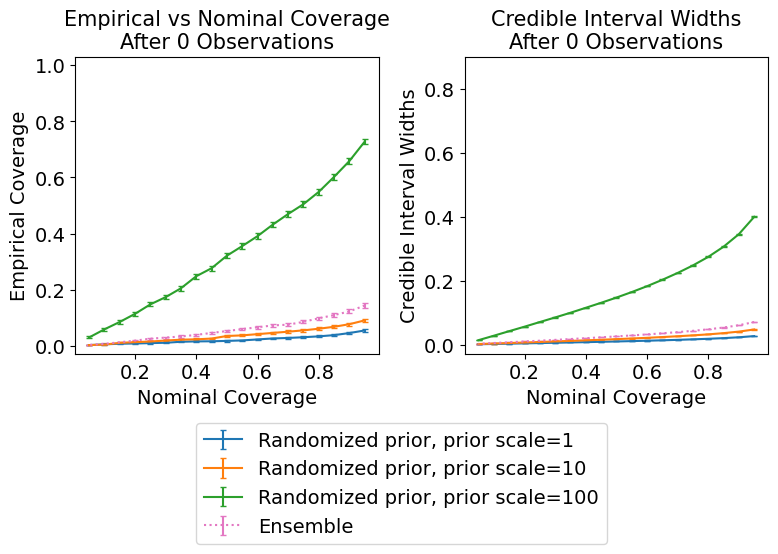

In [32]:
from util import make_plots_good
make_plots_good()
import pandas as pd
figsize=(8,4.4)

df_tmp = pd.DataFrame(cd)

#all_num_prev_obs = [0] 
model_names = np.unique(df_tmp.model)

linestyle = ['-', '-', '-', ':',':',':', ':', ':', '-.', '-.'] #':', ':', ':', ':', ':', ':', ':', ':', ':', ':', ':']

model_names = [
    'Bootstrap, using frozen marginal BERT, randomized prior, prior scale=1',
    'Bootstrap, using frozen marginal BERT, randomized prior, prior scale=10',
    'Bootstrap, using frozen marginal BERT, randomized prior, prior scale=100',
    'Bootstrap, using frozen marginal BERT',
    ]
namedict = {k:(', '.join(k.split(', ')[-2:]).capitalize()) for k in model_names}
namedict['Bootstrap, using frozen marginal BERT, randomized prior']='Old randomized prior'
namedict['Bootstrap, using frozen marginal BERT']='Ensemble'

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#colors = colors[:4] + colors[6:]
colors[3]=colors[6]

for i,num_obs in enumerate([0]): #all_num_prev_obs):
    fig,ax=plt.subplots(1,2,figsize=figsize)
    plt.tight_layout()
    fig.tight_layout()    
    
    for j,model in enumerate(model_names):
        df_tmp2 = df_tmp.loc[(df_tmp.num_prev_obs==num_obs)&(df_tmp.model==model)];
        ax[0].errorbar(1-df_tmp2.sigval, df_tmp2.coverage, yerr=df_tmp2.coverage_stderr, 
                          capsize=2, label=namedict[model], linestyle=linestyle[j],
                         color = colors[j]);
    ax[0].set_title(f'Empirical vs Nominal Coverage\nAfter {num_obs} Observations', fontsize=15)
    ax[0].set_xlabel('Nominal Coverage')
    ax[0].set_ylabel('Empirical Coverage')
    ax[0].set_ylim([-0.03,1.03])
    for j,model in enumerate(model_names):
        df_tmp2 = df_tmp.loc[(df_tmp.num_prev_obs==num_obs)&(df_tmp.model==model)]
        ax[1].errorbar(1-df_tmp2.sigval, df_tmp2.width, yerr=df_tmp2.width_stderr, capsize=2, 
                          label=namedict[model], linestyle=linestyle[j], color = colors[j])#, linestyle=":");
    if num_obs != 1:
        ax[1].set_title(f'Credible Interval Widths\nAfter {num_obs} Observations', fontsize=15)
    else:
        ax[1].set_title(f'Credible Interval Widths\nAfter {num_obs} Observation', fontsize=15)
    ax[1].set_ylabel('Credible Interval Widths')
    ax[1].set_xlabel('Nominal Coverage')
    ax[1].set_ylim([-0.03,0.9])
    plt.tight_layout()
    fig.tight_layout()
    plt.legend(bbox_to_anchor=(0.5,-0.2))

/tmp/7950366.1.debian.q/ipykernel_74450/311396420.py:37: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/7950366.1.debian.q/ipykernel_74450/311396420.py:59: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/7950366.1.debian.q/ipykernel_74450/311396420.py:60: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


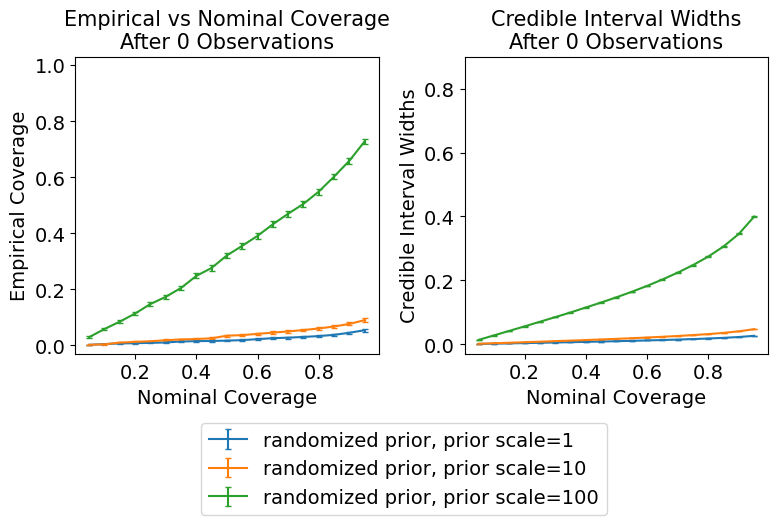

In [72]:
from util import make_plots_good
make_plots_good()
import pandas as pd
figsize=(8,4.4)

df_tmp = pd.DataFrame(cd)

#all_num_prev_obs = [0] 
model_names = np.unique(df_tmp.model)

linestyle = ['-', '-', '-', ':',':',':', ':', ':', '-.', '-.'] #':', ':', ':', ':', ':', ':', ':', ':', ':', ':', ':']

model_names = [
    'Bootstrap, using frozen marginal BERT, randomized prior, prior scale=1',
    'Bootstrap, using frozen marginal BERT, randomized prior, prior scale=10',
    'Bootstrap, using frozen marginal BERT, randomized prior, prior scale=100',
    ]
namedict = {k:', '.join(k.split(', ')[-2:]) for k in model_names}
namedict['Bootstrap, using frozen marginal BERT, randomized prior']='Old randomized prior'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
#colors = colors[:4] + colors[6:]
colors[3]='gray'

for i,num_obs in enumerate([0]): #all_num_prev_obs):
    fig,ax=plt.subplots(1,2,figsize=figsize)
    plt.tight_layout()
    fig.tight_layout()    
    
    for j,model in enumerate(model_names):
        df_tmp2 = df_tmp.loc[(df_tmp.num_prev_obs==num_obs)&(df_tmp.model==model)];
        ax[0].errorbar(1-df_tmp2.sigval, df_tmp2.coverage, yerr=df_tmp2.coverage_stderr, 
                          capsize=2, label=namedict[model], linestyle=linestyle[j],
                         color = colors[j]);
    ax[0].set_title(f'Empirical vs Nominal Coverage\nAfter {num_obs} Observations', fontsize=15)
    ax[0].set_xlabel('Nominal Coverage')
    ax[0].set_ylabel('Empirical Coverage')
    ax[0].set_ylim([-0.03,1.03])
    for j,model in enumerate(model_names):
        df_tmp2 = df_tmp.loc[(df_tmp.num_prev_obs==num_obs)&(df_tmp.model==model)]
        ax[1].errorbar(1-df_tmp2.sigval, df_tmp2.width, yerr=df_tmp2.width_stderr, capsize=2, 
                          label=namedict[model], linestyle=linestyle[j], color = colors[j])#, linestyle=":");
    if num_obs != 1:
        ax[1].set_title(f'Credible Interval Widths\nAfter {num_obs} Observations', fontsize=15)
    else:
        ax[1].set_title(f'Credible Interval Widths\nAfter {num_obs} Observation', fontsize=15)
    ax[1].set_ylabel('Credible Interval Widths')
    ax[1].set_xlabel('Nominal Coverage')
    ax[1].set_ylim([-0.03,0.9])
    plt.tight_layout()
    fig.tight_layout()
    plt.legend(bbox_to_anchor=(0.5,-0.2))

/tmp/7950366.1.debian.q/ipykernel_74450/3777673836.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
/tmp/7950366.1.debian.q/ipykernel_74450/3777673836.py:57: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/7950366.1.debian.q/ipykernel_74450/3777673836.py:58: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


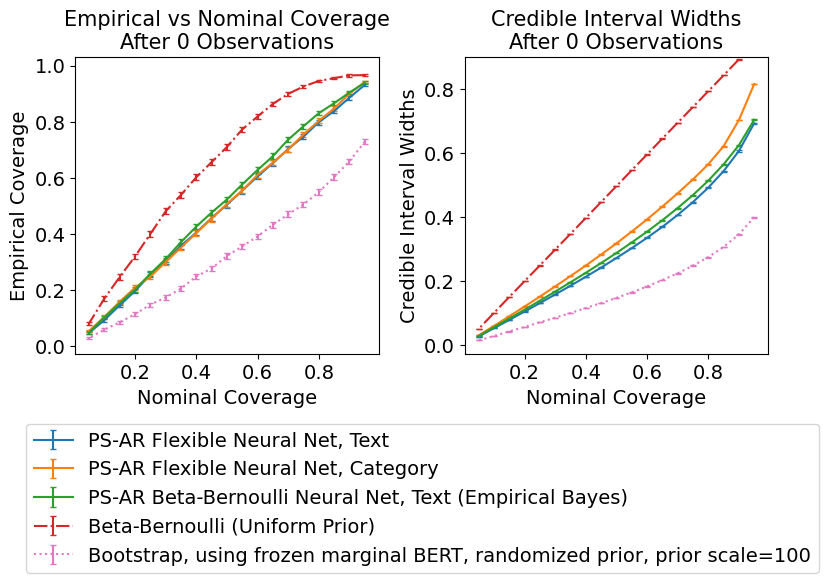

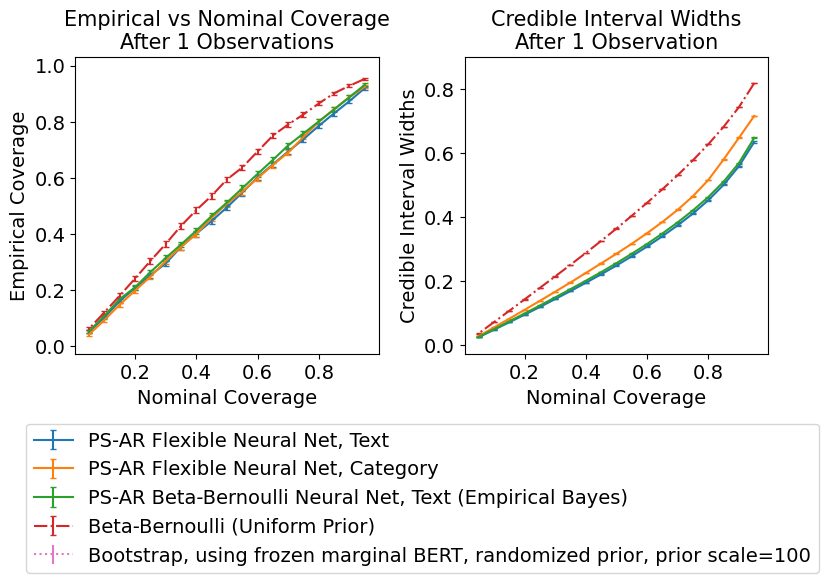

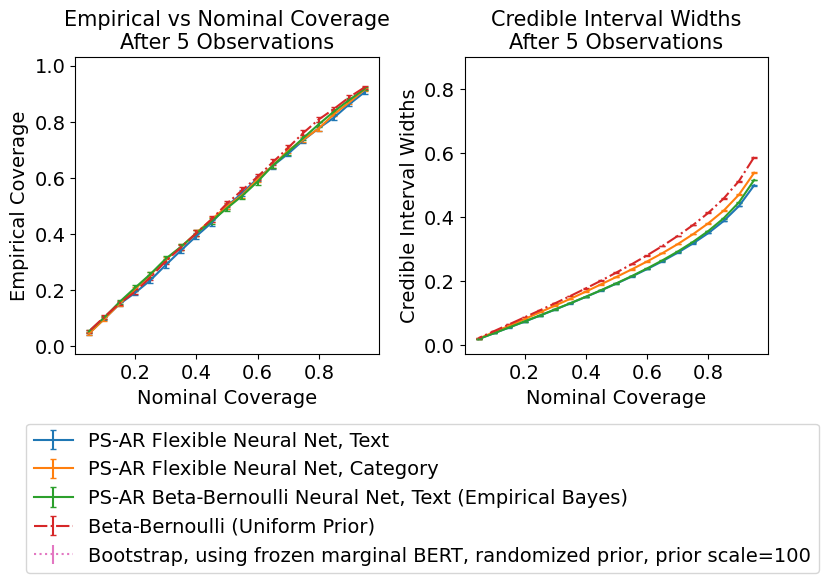

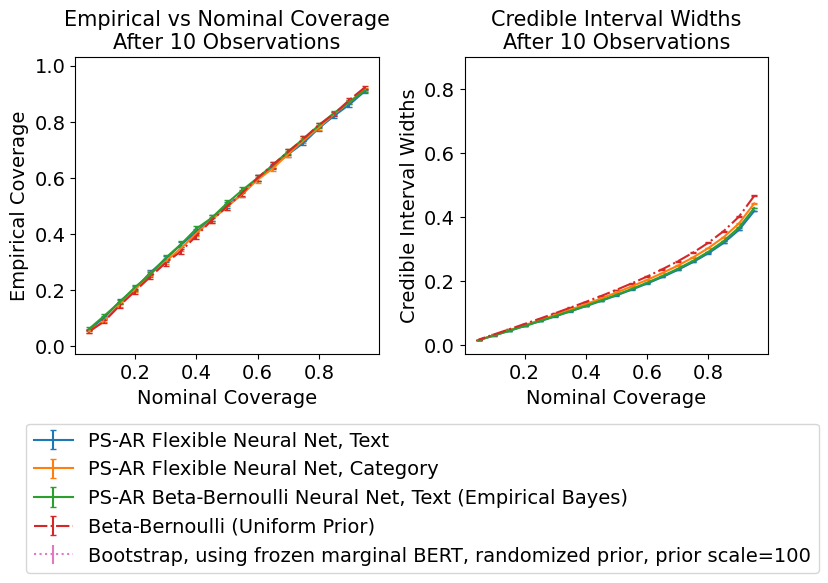

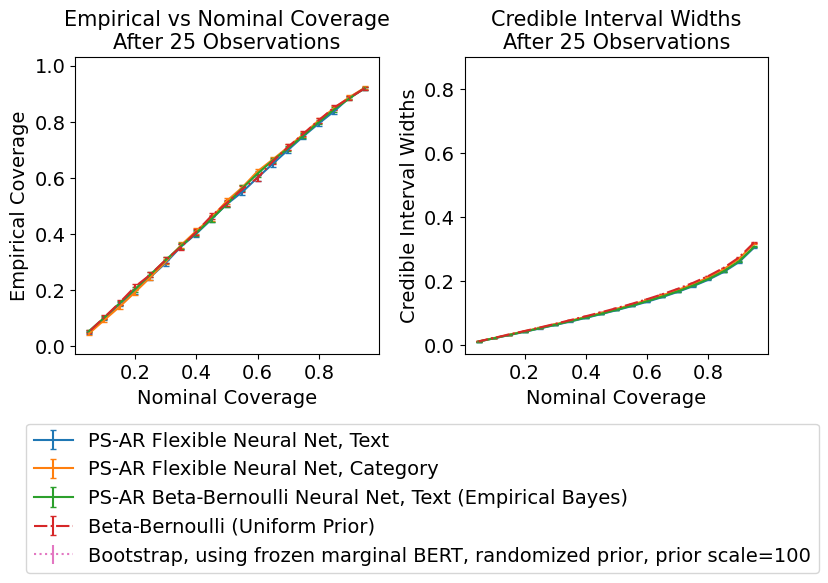

In [94]:
from util import make_plots_good
make_plots_good()
import pandas as pd
figsize=(8,4.4)

df_tmp = pd.DataFrame(cd)

#all_num_prev_obs = [0] 
model_names = np.unique(df_tmp.model)

linestyle = ['-', '-', '-', '-.',':',':', ':', ':', '-.', '-.'] #':', ':', ':', ':', ':', ':', ':', ':', ':', ':', ':']

model_names = [
    'PS AutoReg Neural Net, Text Features',
    'PS AutoReg Neural Net, Category Features', 
    'PS AutoReg Beta-Bernoulli, Text (Empirical Bayes) ',
    'Beta-Bernoulli (Uniform Prior)',
    #'Bootstrap, using frozen marginal BERT',
    'Bootstrap, using frozen marginal BERT, randomized prior, prior scale=100',
]
namedict = {k:k for k in model_names}
namedict['PS AutoReg Neural Net, Text Features'] = 'PS-AR Flexible Neural Net, Text'
namedict['PS AutoReg Neural Net, Category Features'] = 'PS-AR Flexible Neural Net, Category'
namedict['PS AutoReg Beta-Bernoulli, Text (Empirical Bayes) '] = 'PS-AR Beta-Bernoulli Neural Net, Text (Empirical Bayes)'
namedict['Bootstrap, using frozen marginal BERT']='Ensemble'
namedict['Bootstrap, using frozen marginal BERT, randomized prior']='Ensemble, randomized prior'

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = colors[:4] + colors[6:]

for i,num_obs in enumerate(all_num_prev_obs):
    fig,ax=plt.subplots(1,2,figsize=figsize)
    plt.tight_layout()
    fig.tight_layout()    
    
    for j,model in enumerate(model_names):
        df_tmp2 = df_tmp.loc[(df_tmp.num_prev_obs==num_obs)&(df_tmp.model==model)];
        ax[0].errorbar(1-df_tmp2.sigval, df_tmp2.coverage, yerr=df_tmp2.coverage_stderr, 
                          capsize=2, label=namedict[model], linestyle=linestyle[j],
                         color = colors[j]);
    ax[0].set_title(f'Empirical vs Nominal Coverage\nAfter {num_obs} Observations', fontsize=15)
    ax[0].set_xlabel('Nominal Coverage')
    ax[0].set_ylabel('Empirical Coverage')
    ax[0].set_ylim([-0.03,1.03])
    for j,model in enumerate(model_names):
        df_tmp2 = df_tmp.loc[(df_tmp.num_prev_obs==num_obs)&(df_tmp.model==model)]
        ax[1].errorbar(1-df_tmp2.sigval, df_tmp2.width, yerr=df_tmp2.width_stderr, capsize=2, 
                          label=namedict[model], linestyle=linestyle[j], color = colors[j])#, linestyle=":");
    if num_obs != 1:
        ax[1].set_title(f'Credible Interval Widths\nAfter {num_obs} Observations', fontsize=15)
    else:
        ax[1].set_title(f'Credible Interval Widths\nAfter {num_obs} Observation', fontsize=15)
    ax[1].set_ylabel('Credible Interval Widths')
    ax[1].set_xlabel('Nominal Coverage')
    ax[1].set_ylim([-0.03,0.9])
    plt.tight_layout()
    fig.tight_layout()
    plt.legend(bbox_to_anchor=(1.2,-0.2))
